In [351]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from collections import Counter

In [352]:
# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

<h1>DATA COLLECTION</h1>

In [353]:
# connect to the database file
db_con = sqlite3.connect(r'/Users/jmc/GitHub/predict-pwd-strenght-npl/database/password_data.sqlite')

In [354]:
df = pd.read_sql_query('SELECT * FROM Users', db_con)

<h1>DATA CLEANING</h1>

In [355]:
df.head(2)

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1


In [356]:
df.drop(['index'], axis=1, inplace=True)

In [357]:
# check for duplicates
df.duplicated().sum()

0

In [358]:
# check for missing values
df.isnull().sum()

password    0
strength    0
dtype: int64

In [359]:
# check the types of the features
df.dtypes

password    object
strength     int64
dtype: object

In [360]:
# check if there's any row with negative strenght
df['strength'].unique()

array([1, 2, 0])

<h1>DATA ANALYSIS</h1>

Semantic analysis

In [361]:
# how many passwords only have numeric characters?
df['password'].str.isnumeric().sum()

26

In [362]:
# how many passwords only have Upper-case characters?
df['password'].str.isupper().sum()

1506

In [363]:
# how many passwords have alpha characters?
df['password'].str.isalpha().sum()

50

In [364]:
# how many passwords have alphanumeric characters?
df['password'].str.isalnum().sum()

97203

In [365]:
# how many passwords have title-case characters?
df['password'].str.istitle().sum()

932

In [366]:
# how many passwords have special characters?
def get_special_char_pwd(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [367]:
df[df['password'].apply(get_special_char_pwd)==1].shape

(2663, 2)

<h1>FEATURE ENGINEERING</h1>

What are the factors that can impact the strenght of a password? those factors are going to be our features to train our ml model
Factors I'll be using:
- length
- lower frequency
- upper frequency
- digit frequency
- special character frequency

In [368]:
# length
df['length'] = df['password'].str.len()

In [369]:
# lower frequency
def get_lower_freq(row):
    return len([char for char in row if char.islower()])/len(row)

df['lower_freq'] = np.round(df['password'].apply(get_lower_freq),3)

In [370]:
# upper frequency
def get_upper_freq(row):
    return len([char for char in row if char.isupper()])/len(row)

df['upper_freq'] = np.round(df['password'].apply(get_upper_freq),3)

In [371]:
# lower frequency
def get_digit_freq(row):
    return len([char for char in row if char.isdigit()])/len(row)

df['digit_freq'] = np.round(df['password'].apply(get_digit_freq),3)

In [372]:
# special character frequency
def get_special_char_freq(row):
    return len([char for char in row if char in string.punctuation])/len(row)

df['special_char_freq'] = np.round(df['password'].apply(get_special_char_freq),3)

<h1>DATA ANALYSIS ON FEATURES CREATED</h1>

Descriptive Statistics on new features

In [373]:
new_features = ['length', 'lower_freq', 'upper_freq',
       'digit_freq', 'special_char_freq']

In [374]:
for col in new_features:
    print(f'{col} Analysis:')
    print(df.groupby('strength')[col].describe())
    print('\n')

length Analysis:
            count       mean       std   min   25%   50%   75%    max
strength                                                             
0         13622.0   6.550947  0.509951   1.0   6.0   7.0   7.0    7.0
1         73883.0   9.611074  1.338700   8.0   9.0   9.0  10.0   13.0
2         12495.0  15.953421  2.560660  14.0  15.0  16.0  16.0  220.0


lower_freq Analysis:
            count      mean       std  min    25%    50%    75%    max
strength                                                              
0         13622.0  0.708050  0.181488  0.0  0.667  0.714  0.857  1.000
1         73883.0  0.630067  0.217204  0.0  0.556  0.667  0.778  0.923
2         12495.0  0.424679  0.166605  0.0  0.312  0.400  0.500  0.917


upper_freq Analysis:
            count      mean       std  min   25%    50%  75%    max
strength                                                           
0         13622.0  0.012872  0.094251  0.0  0.00  0.000  0.0  1.000
1         73883.0  0.007915 

<Axes: xlabel='strength', ylabel='special_char_freq'>

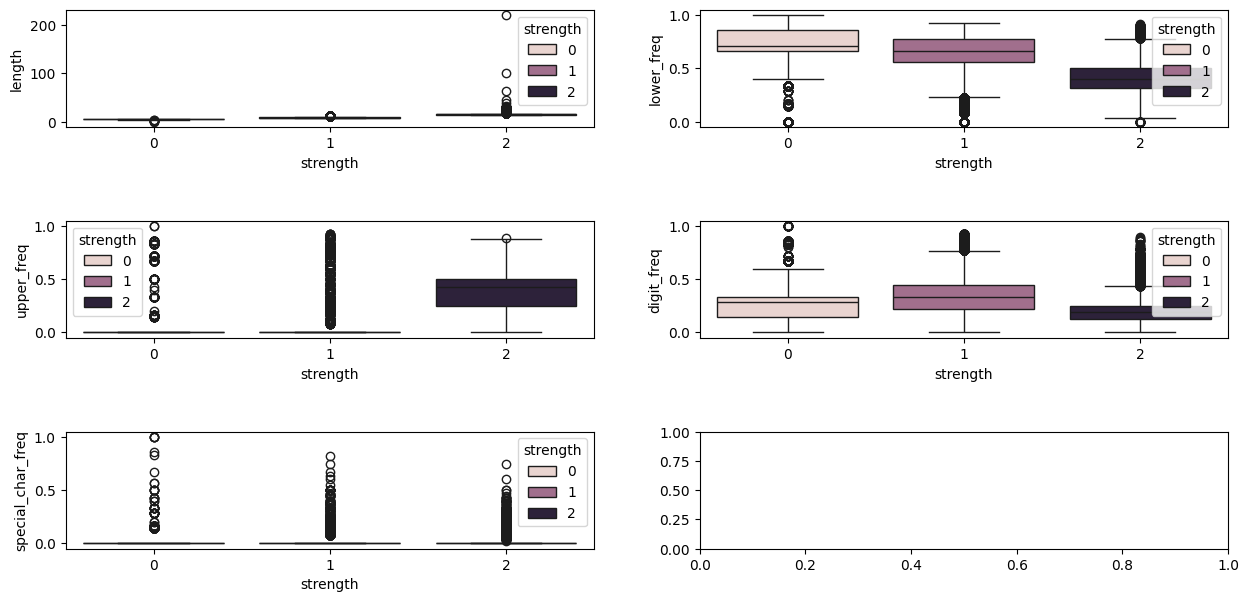

In [375]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(15,7))
plt.subplots_adjust(hspace=0.8)

sns.boxplot(x='strength',y='length', hue='strength', ax=ax1, data=df)
sns.boxplot(x='strength',y='lower_freq', hue='strength', ax=ax2, data=df)
sns.boxplot(x='strength',y='upper_freq', hue='strength', ax=ax3, data=df)
sns.boxplot(x='strength',y='digit_freq', hue='strength', ax=ax4, data=df)
sns.boxplot(x='strength',y='special_char_freq', hue='strength', ax=ax5, data=df)

<h1>FEATURE ENGINEERING</h1>
Feature importance - Univariate analysis

In [376]:
def get_plot_analysis(data, feature):    
    sns.violinplot(
        x='strength', 
        y=feature,
        data=data,
        palette='flare'
        )
    
    sns.displot(
        data = data,
        x = feature,
        kind='kde',
        hue= 'strength',
        palette='flare',
        common_norm = True,
        fill=True
    )

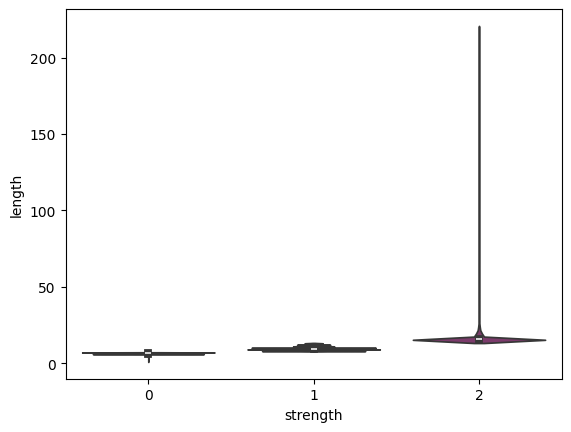

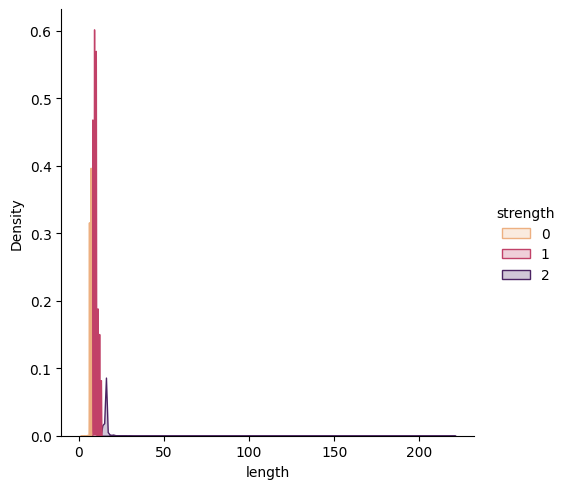

In [377]:
# length
get_plot_analysis(df,'length')

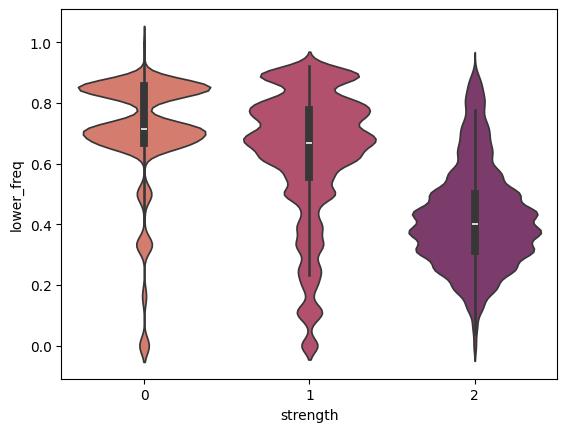

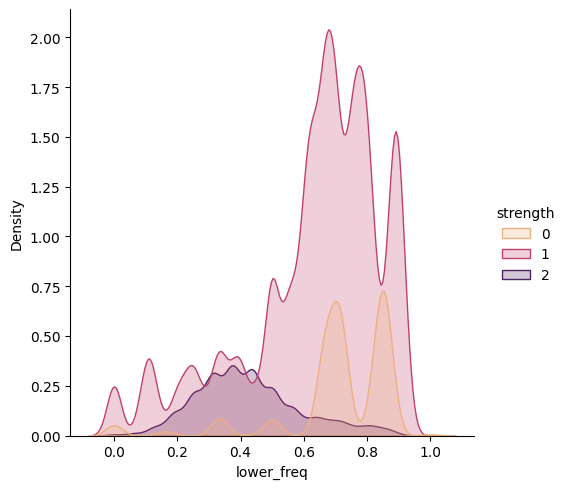

In [378]:
# lower frequency
get_plot_analysis(df,'lower_freq')

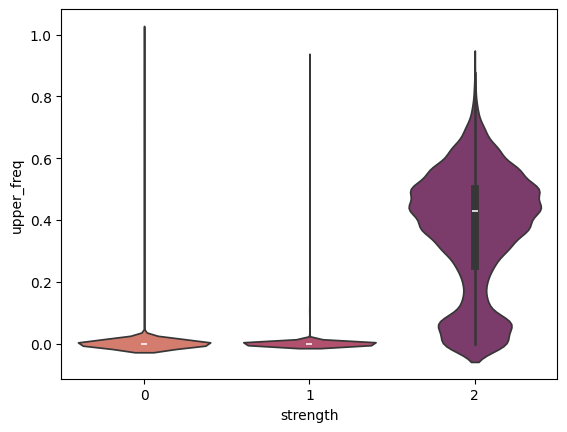

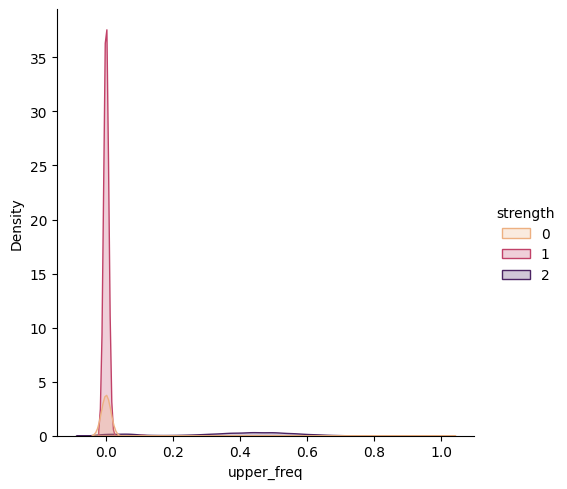

In [379]:
# Upper frequency
get_plot_analysis(df,'upper_freq')

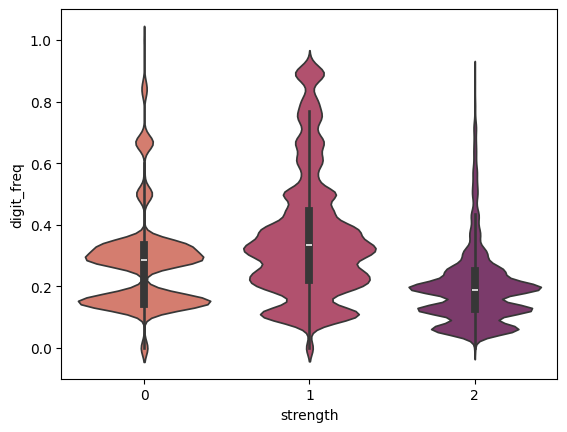

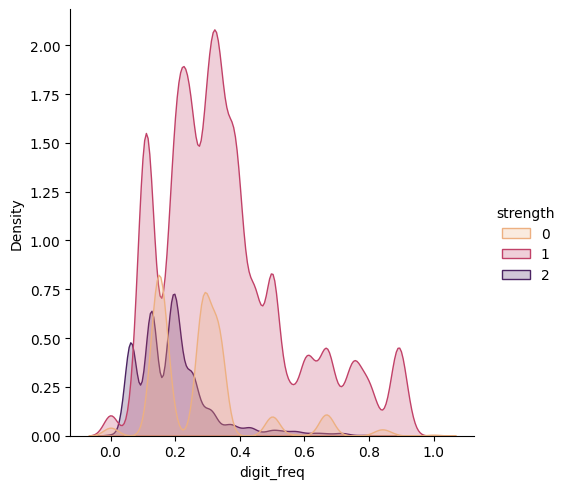

In [380]:
# Digit frequency
get_plot_analysis(df,'digit_freq')

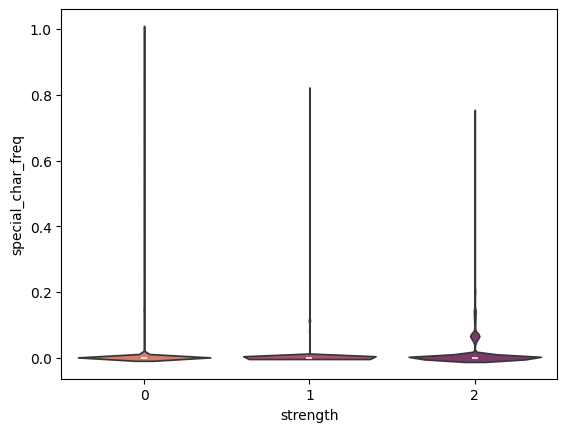

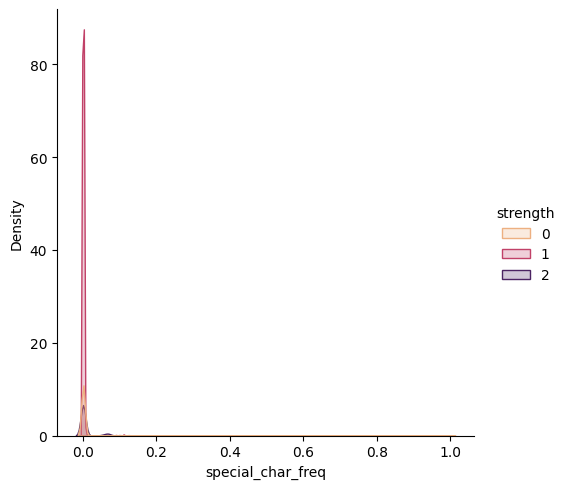

In [381]:
# Special character frequency
get_plot_analysis(df,'special_char_freq')

NLP Techniques

In [382]:
# shuffling the data
df_shuffled = df.sample(frac=1)

In [383]:
vectorizer = TfidfVectorizer(analyzer='char')

In [384]:
X = vectorizer.fit_transform(df_shuffled['password'])

In [385]:
df_vector = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

In [386]:
# we'll also include length and lowercase frequency in this dataframe

df_vector['length'] = df_shuffled['length']
df_vector['lower_freq'] = df_shuffled['lower_freq']

<h1>ML MODEL</h1>
Logistic Regression

In [387]:
X = df_vector
y = df_shuffled['strength']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [389]:
clf = LogisticRegression(
    multi_class='multinomial'
)

In [390]:
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [391]:
y_pred = clf.predict(X_test)

Testing model in a random password

In [392]:
user_pwd = 'q1w2e3r4t5.1'

In [393]:
sample_array = np.array([user_pwd])

In [394]:
sample_matrix = vectorizer.transform(sample_array)

In [395]:
pwd_len = len(user_pwd)

In [396]:
pwd_lower_freq = len([c for c in user_pwd if c.islower()])/len(user_pwd)

In [399]:
new_matrix = np.append(sample_matrix.toarray(), (pwd_len,pwd_lower_freq))

In [401]:
new_matrix = new_matrix.reshape(1,101)

In [405]:
clf.predict(new_matrix)

array([1])